### An Introduction to P2CPs

In [1]:
from itertools import combinations, product

import matplotlib.pyplot as plt
import numpy as np
from hiveplotlib import p2cp_n_axes
from hiveplotlib.datasets import four_gaussian_blobs_3d
from hiveplotlib.viz import p2cp_viz

#### Motivation: Why Polar Parallel Coordinates Plots (P2CPs)?

Multidimensional data visualization is routinely stuck between two conflicting truths—humans are very good at finding patterns in data that can be visualized in two dimensions, but plotting high-dimensional data in 2d requires representational tricks that can come with an interpretability trade-off.

Assigning dimensions to _axes_ in flatland, a technique most notably used with the [Parallel Coordinates Plot (PCP)](https://en.wikipedia.org/wiki/Parallel_coordinates), allows one to represent a multidimensional point as a _polyline_ while preserving univariate relationships as well as a subset of bivariate relationships.

By adapting the PCP to polar coordinates and following some of the visual techniques used for Hive Plots&mdash;curved edges, the unique interpretation capabilities when choosing 3 axes, and the use of small multiples&mdash;the resulting compact visualization lends itself well to the visual exploration of multidimensional data.

Furthermore, if forced to look at a single, static visualization, a 3-axis P2CP is in fact _more informative_ than a 3-dimensional Scatterplot, which we will show here with a toy example.

In this notebook, we demonstrate the resulting visualization, the Polar Parallel Coordinates Plot (P2CP), on toy Gaussian data, replicating Figures 3, 4, and 5 in [Koplik and Valente, 2021](https://arxiv.org/abs/2109.10193).

#### Visualizing Gaussian Blobs in 3D

As a simple example, we will consider four nicely-separable Gaussian blobs in 3-space, with each blob centered on a different corner of a cube.

Below, we visualize the resulting dataset in three dimensions. Note, with our carefully selected viewing angle, we can perfectly visually separate the four clusters.

In [2]:
# color palette for the blobs
COLORS = ["#0173b2", "#de8f05", "#029e73", "#cc78bc"]

Let's start with a `pandas` dataframe of our gaussian blob data, which we will pull from `hiveplotlib.datasets`.

In [3]:
df = four_gaussian_blobs_3d()
df.sample(5, random_state=0)

X         Y         Z  Label
18  -0.644181  0.197561  0.214932      0
170  4.700813  0.383559  1.195842      3
107 -0.278398  4.448891  0.150858      2
98  -0.479467  0.281199  4.854184      1
177  4.500486  0.652254  0.075638      3

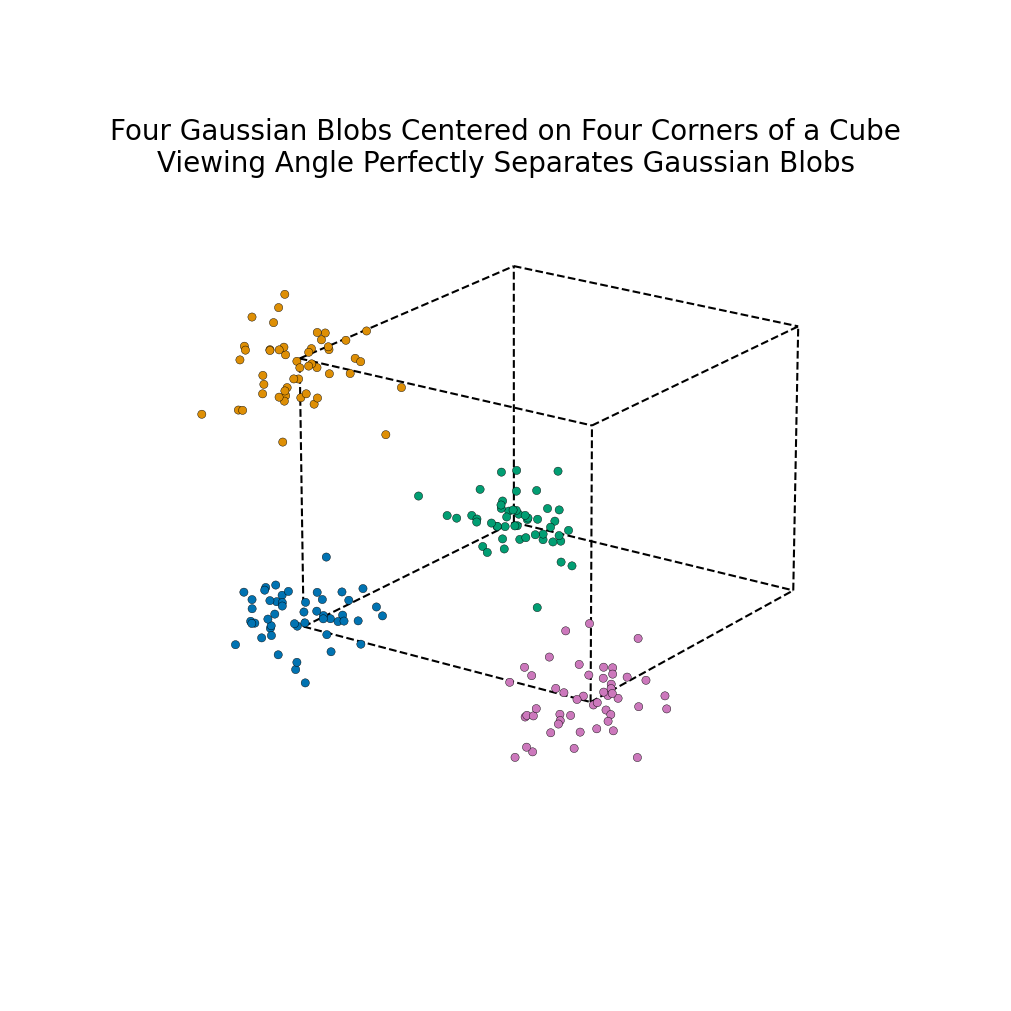

In [4]:
# 3d plot of scenario
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
ax = fig.add_subplot(111, projection="3d")

# corners of a cube
coords = list(product(*[(0, 5)] * 3))

# plot the edges of the cube
for i, j in combinations(coords, 2):
    # skip diagonals
    if np.linalg.norm(np.array(i) - np.array(j)) == 5:
        plt_vals = [[i[k], j[k]] for k in range(3)]
        ax.plot(*plt_vals, color="black", ls="--")

# select and plot only a subset of Gaussian blobs
colors = [COLORS[label] for label in df.Label]
ax.scatter(df.X, df.Y, df.Z, alpha=1, facecolor=colors, edgecolor="black", lw=0.3, s=35)

# carefully chosen viewing angle that perfectly separates our blobs
ax.view_init(20, -55)

ax.set_title(
    "Four Gaussian Blobs Centered on Four Corners of a Cube\n"
    "Viewing Angle Perfectly Separates Gaussian Blobs",
    size=20,
    y=0.9,
)

ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_axis_off()
plt.show()

#### Viewing Angles Matter for 3D Viz

If we change the angle of the visualization, however, we can lose the ability to quickly disentangle the blobs, demonstrated in the figure below.

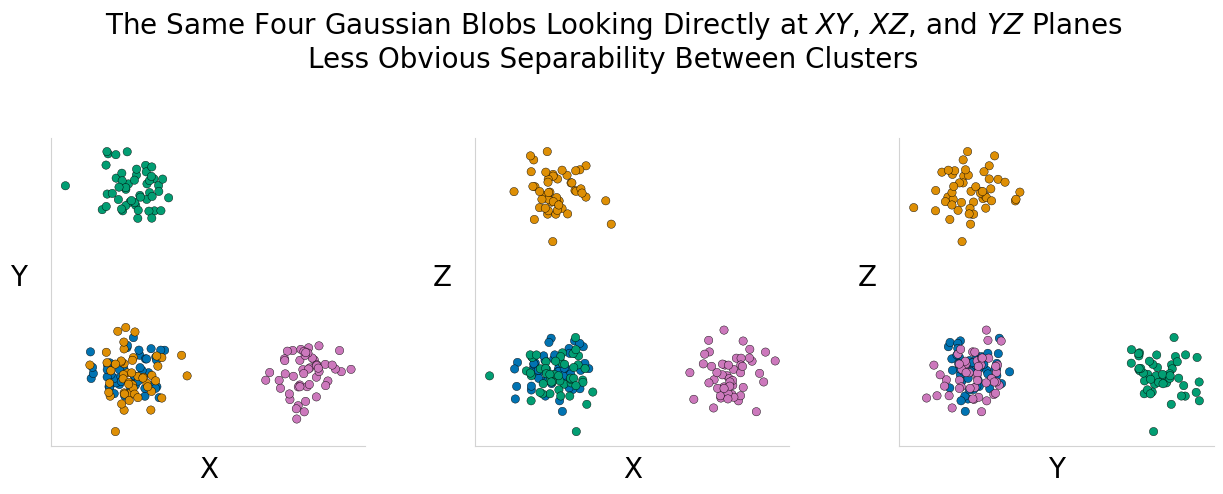

In [5]:
# put our 4 blobs of interest into a single dataframe
combs = combinations(["X", "Y", "Z"], 2)

# scatter plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for comb, ax in zip(combs, axes):
    ax.scatter(df[comb[0]], df[comb[1]], facecolor=colors, edgecolor="black", lw=0.3)
    ax.set_xlabel(comb[0], size=20)
    ax.set_ylabel(comb[1], rotation=0, size=20, labelpad=20)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines["bottom"].set_color("lightgray")
    ax.spines["left"].set_color("lightgray")
    ax.spines["right"].set_color("None")
    ax.spines["top"].set_color("None")
fig.suptitle(
    "The Same Four Gaussian Blobs "
    "Looking Directly at $XY$, $XZ$, and $YZ$ Planes\n"
    "Less Obvious Separability Between Clusters",
    size=20,
    y=1.2,
)
fig.subplots_adjust(wspace=0.35)
plt.show()

At no point in any of the above three figures can we see four distinct clusters. In fact, the only way to distinguish the blue cluster is to note it's varying interactions with _other_ clusters over _multiple_ figures.

Now, we have of course contrived the worst case scenario for our blobs by choosing to look directly at 2D planes given our construction of data. Nonetheless, when doing an exploration of a high-demensional dataset with unknown properties, no one wants to ask the question, "will the patterns I see persist if I shift the angle slightly?"

P2CPs are ideal for unambiguously visualizing three dimensions in flatland because they preserve all axis relationships (univariate, bivariate, and trivariate) without requiring any choice of viewing angle.

#### Separating Blobs in 2D with P2CPs

Other than choosing kwargs for the different `Label` values, we can use the high-level functionality of the `p2cp_n_axes()` call to quickly generate the P2CP representation of the above dataframe.

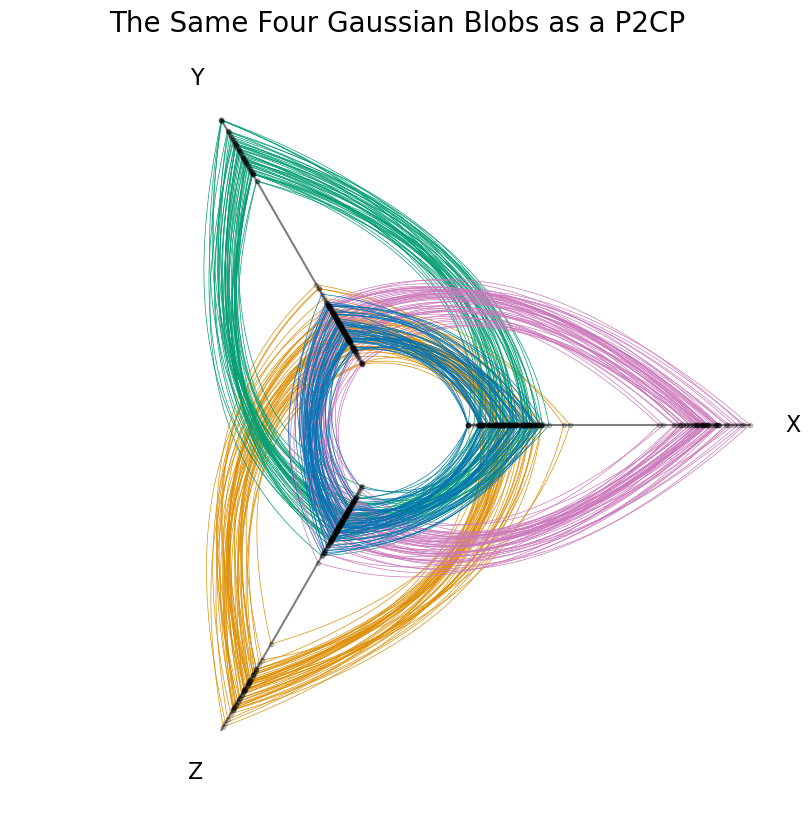

In [6]:
# align the colors with the figure from the paper
indices_dict = [{"color": color} for color in COLORS]

p2cp = p2cp_n_axes(
    data=df,
    split_on="Label",
    vmins=[-1] * 3,
    vmaxes=[6] * 3,
    all_edge_kwargs={"alpha": 1, "lw": 0.5},
    indices_list_kwargs=indices_dict,
)

# the (0, 0, 0) blob gets plotted first by default
#  ends up being obscured by other edges unless
#  we bring its lines to the front by changing zorder
p2cp.add_edge_kwargs(tag=0.0, zorder=3)

fig, ax = p2cp_viz(p2cp, node_kwargs={"s": 10, "alpha": 0.2})
ax.set_title("The Same Four Gaussian Blobs as a P2CP", size=20)
plt.show()

With the resulting P2CP, despite restricting ourselves to 2d, we can easily distinguish the four unique clusters by the shape of the loops.

#### References

Koplik, Gary, and Ashlee Valente. "The Parallel Coordinates Plot Revisited: Visual Extensions from Hive Plots, Heterogeneous Correlations, and an Exploration of Covid-19 Data in the United States." arXiv preprint arXiv:2109.10193 (2021).